# 당뇨와 고혈압 질병 예측
- BTH_G : 연령(그룹)
- SBP : 수축기혈압
- DBP : 이완기혈압
- FBS : 공복혈당
- SEX : 성별(남성:1, 여성:2)
- DIS : 고혈압/당뇨병 진료여부
  - 고혈압/당뇨병 진료내역 있음: 1
  - 고혈압 진료내역 있음: 2
  - 당뇨병 진료내역 있음: 3
  - 고혈압/당뇨병 진료내역 없음: 4
- BMI : 체질량지수

## 정상 vs 비정상
- 4(정상) : 0
- 1 / 2 / 3(비정상) : 1

- 0(정상) 기준으로 1(비정상) 오버샘플링 : RandomOversampling
- 1(비정상) : 1 / 2 / 3 각각 레이블링 됨

1 / 2 / 3 = 비율) 1 : 3 : 1
=> 1 : 1 : 1 비율로 오버샘플링

1 / 0 = 비율) 1 : 3
=> 1 : 1 비율로 오버샘플링

# LightGBM
+
## RandomOversampling + 질병 1, 2, 3 비율 => 1 : 1 : 1

### LightGBM 설치:

```
pip3 install lightgbm

```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd # 시리즈, 데이터프레임 포맷 데이터 처리를 위한 라이브러리
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import pickle # 객체 입출력을 위한 라이브러리

from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score


# LightGBM 임포트
from lightgbm import LGBMClassifier # LightGBM 불러오기

from pandas.core.common import random_state
from sklearn.ensemble import RandomForestClassifier # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier # 의사결정나무 분류 알고리즘

import matplotlib.pyplot as plt
import seaborn as sns

# 모델 평가를 위한 metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## 데이터 불러오기

In [ ]:
# Disease 

df = pd.read_csv('/content/drive/MyDrive/health/data/data(over_dis_vs_nor).csv', encoding='cp949')
df

,SEX,BTH_G,SBP,DBP,FBS,BMI,DIS,Dis
0,0,1,90,50,86,20.1,2,1
1,0,1,120,80,90,27.0,3,1
2,0,1,100,60,112,31.8,2,1
3,0,1,170,120,86,23.3,2,1
4,0,1,135,80,104,35.0,2,1
...,...,...,...,...,...,...,...,...
1481319,1,21,130,90,185,26.3,3,1
1481320,1,18,140,100,120,28.8,2,1
1481321,0,12,100,60,101,23.0,3,1
1481322,1,20,134,72,168,23.1,3,1


In [ ]:
df.drop(df[df['Dis']==0].index, inplace=True)
df

,SEX,BTH_G,SBP,DBP,FBS,BMI,DIS,Dis
0,0,1,90,50,86,20.1,2,1
1,0,1,120,80,90,27.0,3,1
2,0,1,100,60,112,31.8,2,1
3,0,1,170,120,86,23.3,2,1
4,0,1,135,80,104,35.0,2,1
...,...,...,...,...,...,...,...,...
1481319,1,21,130,90,185,26.3,3,1
1481320,1,18,140,100,120,28.8,2,1
1481321,0,12,100,60,101,23.0,3,1
1481322,1,20,134,72,168,23.1,3,1


In [ ]:
# 1,0 정답 레이블 삭제
df.drop(['Dis'], axis=1, inplace=True)
df

,SEX,BTH_G,SBP,DBP,FBS,BMI,DIS
0,0,1,90,50,86,20.1,2
1,0,1,120,80,90,27.0,3
2,0,1,100,60,112,31.8,2
3,0,1,170,120,86,23.3,2
4,0,1,135,80,104,35.0,2
...,...,...,...,...,...,...,...
1481319,1,21,130,90,185,26.3,3
1481320,1,18,140,100,120,28.8,2
1481321,0,12,100,60,101,23.0,3
1481322,1,20,134,72,168,23.1,3


In [ ]:
df.notnull().sum()

SEX      740662
BTH_G    740662
SBP      740662
DBP      740662
FBS      740662
BMI      740662
DIS      740662
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 740662 entries, 0 to 1481323
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SEX     740662 non-null  int64  
 1   BTH_G   740662 non-null  int64  
 2   SBP     740662 non-null  int64  
 3   DBP     740662 non-null  int64  
 4   FBS     740662 non-null  int64  
 5   BMI     740662 non-null  float64
 6   DIS     740662 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 45.2 MB


In [ ]:
# feature와 target 분리(설명변수 및 목표변수 분리)
x = df.drop(['DIS'], axis=1) # df[df.columns.difference(['target'])]
y = np.array(df['DIS']) # y = df['target']

In [ ]:
# 전체 데이터에서 학습데이터셋과 테스트셋을 나눔
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, shuffle=True, random_state = 42) # 기본 0.25

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# train과 test데이터의 비율을 6:4로 나누어주고
# 0.4비율이 된 test데이터를 다시 각 0.5 비율로 validation과 test를 나누어 줌
# 최종 결과가 train : test : validation = 6 : 2 : 2 비율

# train set에서 train과 validation set를 나눔 # x,y,test_size=0.4
# x_test,x_val,y_test,y_val=train_test_split(x_test,y_test,test_size=0.5, shuffle=True)

print(x_train.shape)
print(y_train.shape)
# print(x_val.shape)
# print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(592529, 6)
(592529,)
(148133, 6)
(148133,)


### 파라미터 세팅
![img](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F1PyOG%2FbtqzusXhcyY%2FwijjRmggTpggOpi4GKMEQ1%2Fimg.png)

- [LightGBM](https://injo.tistory.com/48)

- [lightGBM / XGBoost 파라미터 설명](http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/)

- [파라미터 설명과 코드 실습](https://for-my-wealthy-life.tistory.com/24)

### lightgbm 데이터셋으로 변환

In [ ]:
# 라이트GBM without tuning
import lightgbm as lgb
from lightgbm import LGBMClassifier as lgbm

train_ds = lgb.Dataset(x_train, label = y_train)
test_ds = lgb.Dataset(x_test, label = y_test)
# val_ds = lgb.Dataset(x_val, label = y_val)

In [117]:
# 트리 개수는 100개로 지정
lgbm_wrapper = lgbm(n_estinators=100, learning_rate=0.1, max_depth=-1, min_data=20, num_leaves=15, bagging_fraction=1, feature_fraction=0.5, application= 'multiclass') # boosting_type='gbdt', max_bin=255


```
params = {'num_iterations': 1000, # 1000이상
           'objective': 'binary', # multi:softmax
           'learning_rate': 0.1, # 0.05~0.1
           'max_depth': -1,
            # default는 -1로 제한없이 분기 
           'min_data': 20,
           'num_leaves' : 15,
            # depth가 4라면 (2의 4제곱 – 1) = 15 / 31
           'boosting': 'gbdt', 
           'bagging_fraction': 1.0,
           'feature_fraction': 0.9,
            # 1이 기본값이나, 0.7~0.9 정도로 세팅하는 편이 일반적
            'early_stopping_round': 100,
            # validation셋이 없으면 무용지물
           'metric': 'mse'} # regression_l2(MSE)
          
            # L1/L2 규제 : 정확도에 어떻게 영향을 줄지 예측하기가 힘들어 default인 0으로 놔두는 편
           'lambda_l1': 0.0,
           'lambda_l2': 0.0, 
           'max_bin' : 255 # default

           'is_training_metric': True, # 회귀?
           'num_leaves': 144, # 회귀?

           'bagging_freq': 1, 
           'seed':2018}
```





- Metric / Loss 관련 파라미터 (★★★)
당연히, 학습하려는 목적에 따라 다음의 metric을 설정하여야 하며, lightGBM에서 제공하는 파라미터는 다음과 같다.
  - binary(Cross Entropy)
  - multiclass(Cross Entropy)
  - regression_l2(MSE)
  - regression_l1 (MAE)
  - mape (MAPE)
  - poisson (Log Transformation)
  - quantile (Quantile)
  - huber (Huber loss, MAE approx)
  - fair (Fair loss, MAE approx)
  - gamma (Residual Deviance)
  - lambdarank
  - tweedie

### 훈련

In [118]:
# LGMB도 XGBoost처럼 early stopping 가능

evals = [(x_test, y_test)]
lgbm_wrapper.fit(x_train, y_train, eval_metric='logloss', eval_set = evals, verbose = True) # early_stopping_rounds = 100
# lgbm_roc_score = roc_auc_score(y_val, lgbm_wrapper.predict_proba(x_val), average = 'macro', multi_class='ovo')

preds = lgbm_wrapper.predict(x_test)

[1]	valid_0's multi_logloss: 1.09152	valid_0's multi_logloss: 1.09152
[2]	valid_0's multi_logloss: 1.08692	valid_0's multi_logloss: 1.08692
[3]	valid_0's multi_logloss: 1.0664	valid_0's multi_logloss: 1.0664
[4]	valid_0's multi_logloss: 1.04916	valid_0's multi_logloss: 1.04916
[5]	valid_0's multi_logloss: 1.04296	valid_0's multi_logloss: 1.04296
[6]	valid_0's multi_logloss: 1.03508	valid_0's multi_logloss: 1.03508
[7]	valid_0's multi_logloss: 1.02222	valid_0's multi_logloss: 1.02222
[8]	valid_0's multi_logloss: 1.01104	valid_0's multi_logloss: 1.01104
[9]	valid_0's multi_logloss: 1.00506	valid_0's multi_logloss: 1.00506
[10]	valid_0's multi_logloss: 1.00086	valid_0's multi_logloss: 1.00086
[11]	valid_0's multi_logloss: 0.996187	valid_0's multi_logloss: 0.996187
[12]	valid_0's multi_logloss: 0.991433	valid_0's multi_logloss: 0.991433
[13]	valid_0's multi_logloss: 0.986919	valid_0's multi_logloss: 0.986919
[14]	valid_0's multi_logloss: 0.977298	valid_0's multi_logloss: 0.977298
[15]	vali

[다중분류](https://wikidocs.net/84190)
[ovo, ovr 에러](https://magicode.tistory.com/38)

In [124]:
predict_train = lgbm_wrapper.predict(x_train)
print("train score : {}".format(lgbm_wrapper.score(x_train, y_train)))
predict_test = lgbm_wrapper.predict(x_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, lgbm_wrapper.predict(x_test)))
print("test score : {}".format(lgbm_wrapper.score(x_test, y_test)))

train score : 0.5806095566630494
              precision    recall  f1-score   support

           1       0.55      0.46      0.50     49446
           2       0.58      0.78      0.66     49064
           3       0.60      0.49      0.54     49623

    accuracy                           0.58    148133
   macro avg       0.58      0.58      0.57    148133
weighted avg       0.58      0.58      0.57    148133

test score : 0.5755908541648384


---

In [119]:
# model = lgb.train(params, train_ds, 1000, verbose_eval=100, early_stopping_rounds=100, valid_sets = val_ds)

In [120]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average = 'macro')
    recall = recall_score(y_test, y_pred, average = 'macro')
    F1 = f1_score(y_test, y_pred, average = 'macro')
    # AUC = roc_auc_score(y_test, y_pred, multi_class='ovo')
    print('오차행렬:\n', confusion)
    print('\n정확도:{:.4f}'.format(accuracy))
    print('정밀도:{:.4f}'.format(precision))
    print('재현율:{:.4f}'.format(recall))
    print('F1:{:.4f}'.format(F1))
    # print('AUC:{:.4f}'.format(AUC))

In [121]:
get_clf_eval(y_test, preds)

오차행렬:
 [[22840 15201 11405]
 [ 6439 38074  4551]
 [12537 12736 24350]]

정확도:0.5756
정밀도:0.5757
재현율:0.5762
F1:0.5679


---

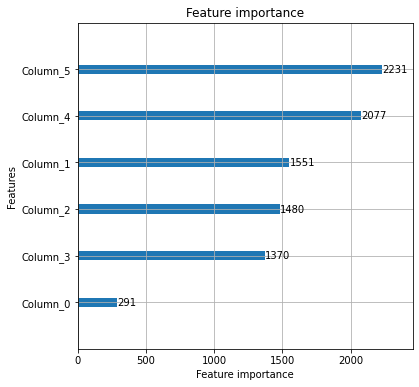

In [ ]:
# plot_importance()를 이용한 피처 중요도 시각화

from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plot_importance(lgbm_wrapper, max_num_features=6, ax=ax) # 상위 6개만

### 에러 측정

In [ ]:
# mse = mean_squared_error(y_test, predict_test)
# r2 = r2_score(y_test, predict_test)

In [ ]:
# print('Mean squared error: ', mse)
# print('R2 score: ', r2)

Mean squared error:  1.666438942459584
R2 score:  -1.5003302010237398


In [ ]:
# final_result = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(predict_test)], axis = 1)

In [ ]:
# final_result.columns = ['label','predict']

In [ ]:
# sns.regplot(x = 'label', y = 'predict', data = final_result)

----

### LGBMClassifier 상위 모델(?) -> HistGradientBoostingClassifier

In [ ]:
# lgb_clf = lgb.LGBMClassifier(num_leaves=31, objective='binary')
# lgb_clf.fit(x_train, y_train)
# y_pred = lgb_clf.predict(x_test)
# accuracy_score(y_test, y_pred)

# d_train = lgb.Dataset(x_train, label=y_train)
# param = {'num_iterations': 100, 'learning_rate' : 0.1, 'max_depth' : -1, 'objective': 'binary', 'metric':'auc'}

In [ ]:
# from sklearn.ensemble import HistGradientBoostingClassifier as hgbc

In [ ]:
# hgbc.score(x_train)

### 그리드 서치

In [ ]:
# g_lgbm = GridSearchCV(estimator=lgb_estimator, param_grid=gridParams, n_jobs = 3, cv= 3)

# lgb_model = g_lgbm.fit(X=X_train, y=y_train, eval_set = (X_valid, y_valid))

NameError: ignored